## Imports & Tested Version 

In [1]:
import sys, torch, scprep
sys.path.append('../')
import warnings; warnings.filterwarnings('ignore')
from AAnet_torch import *
from torch import optim
import torchvision; from torchvision import datasets, transforms
import numpy as np
import matplotlib; import matplotlib.pyplot as plt

In [2]:
print ('Python', sys.version)
print ('torch', torch.__version__)
print ('torchvision', torchvision.__version__)
print ('scprep', scprep.__version__)
print ('numpy', np.__version__)
print ('matplotlib', matplotlib.__version__)

Python 3.8.18 | packaged by conda-forge | (default, Oct 10 2023, 15:44:36) 
[GCC 12.3.0]
torch 2.4.0+cu121
torchvision 0.19.0+cu121
scprep 1.2.3
numpy 1.22.4
matplotlib 3.7.3


## Load MNIST data

In [3]:
# Load MNIST and normalize for tanh activation [-1,1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_all = mnist.data.numpy()
data_all = data_all / 255
data_all = (data_all * 2) - 1 # norm
labels = mnist.train_labels.numpy()

In [4]:
# pick single digit
digit = 4
idx_digit = mnist.train_labels.numpy() == digit
data_digit = data_all[idx_digit,]
data_digit = np.reshape(data_digit, (data_digit.shape[0], -1))
print(data_digit.shape)

(5842, 784)


## AAnet

In [5]:
N_ARCHETYPES = 3
data_loader = torch.utils.data.DataLoader(data_digit, batch_size=256, shuffle=True, num_workers=4)

# warm-start model with graph-based extrema for improved results
extrema = torch.Tensor(utils.get_laplacian_extrema(data_digit, n_extrema=N_ARCHETYPES))
extrema = torch.Tensor(data_digit[extrema.numpy().astype(int)])

In [6]:
device = torch.device('cpu')
model = models.AAnet_vanilla(noise=0.05, layer_widths=[256, 128],
                             n_archetypes=N_ARCHETYPES, 
                             input_shape=data_digit.shape[1],
                             device=device, diffusion_extrema=extrema)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Run AAnet

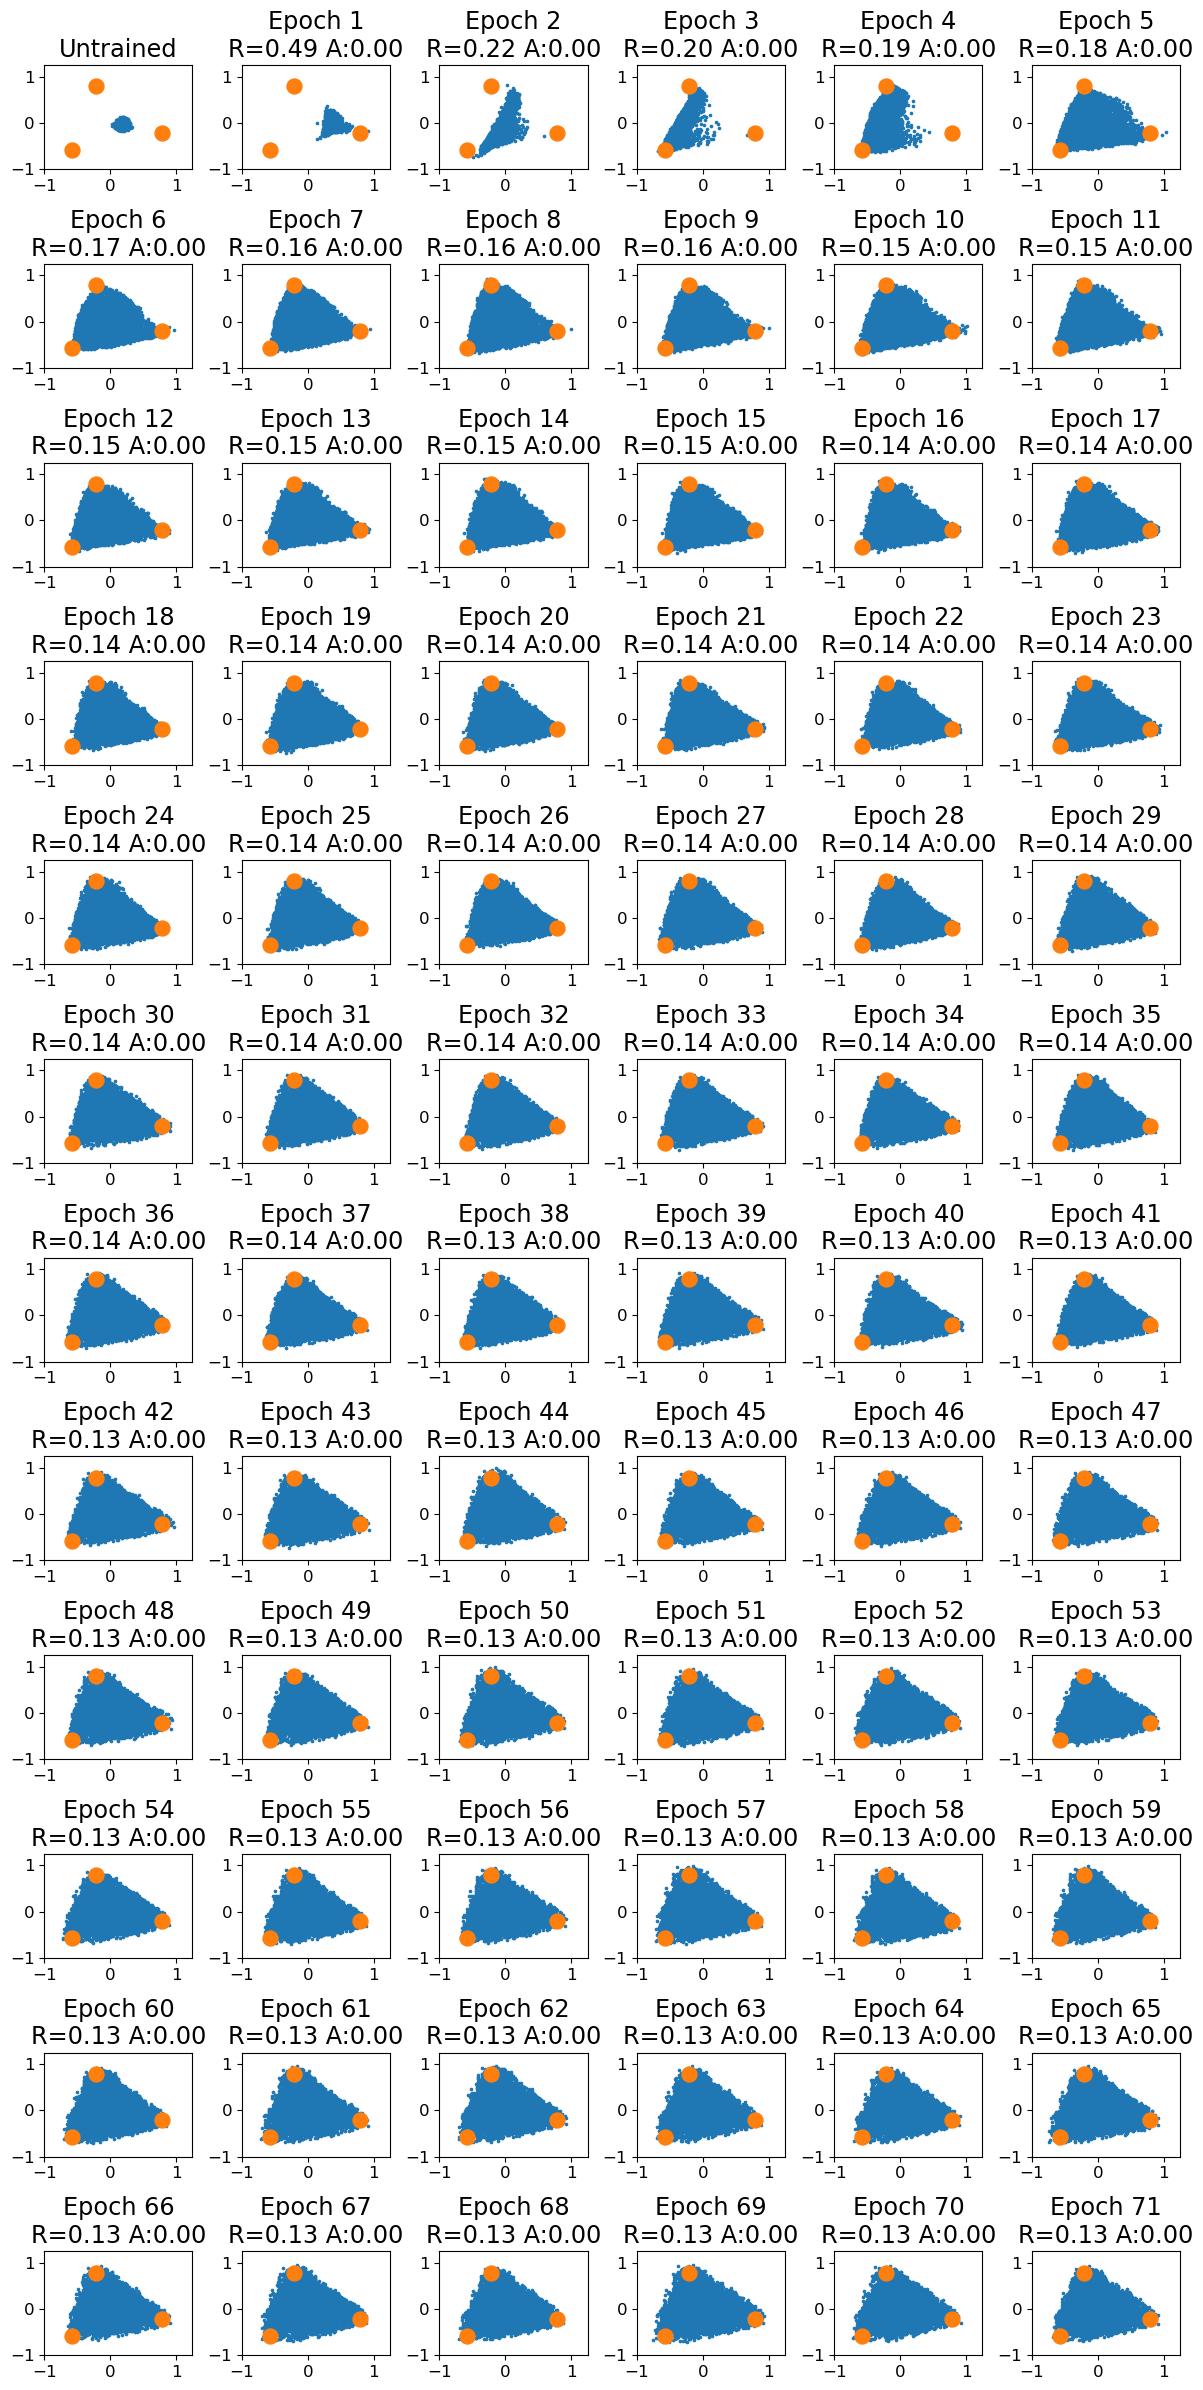

In [7]:
n_row = 12
n_col = 6
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))

for i, ax in enumerate(axes.flatten()):
    if i == 0:
        r_loss = a_loss = 0

        title='Untrained'
    else:
        # gamma_extrema parameter weights how informative graph-based extrema are to model
        # higher gamma_extrema = more pushing AAnet to learn the archetypes learned from the graph-based approach
        loss, r_loss, a_loss=utils.train_epoch(model, data_loader, optimizer, epoch=i, gamma_extrema=1.0)
        title='Epoch {}\nR={:.2f} A:{:.2f}'.format(i, r_loss, a_loss)

    archetypal_embedding = model.encode(torch.Tensor(data_digit))

    scprep.plot.scatter2d(archetypal_embedding.detach().cpu().numpy(), title=title, ax=ax)
    scprep.plot.scatter2d(model.get_n_simplex(model.n_archetypes).cpu().numpy(), ax=ax)
    ax.set_xlim(-1, 1.25)
    ax.set_ylim(-1, 1.25)

fig.tight_layout()

### Visualize latent space

In [8]:
archetypal_embedding = model.encode(torch.Tensor(data_digit))
vertices_embedding = model.get_n_simplex(n=3)
barycentric_archetypal_embedding = model.euclidean_to_barycentric(archetypal_embedding).detach().numpy()

<Axes: >

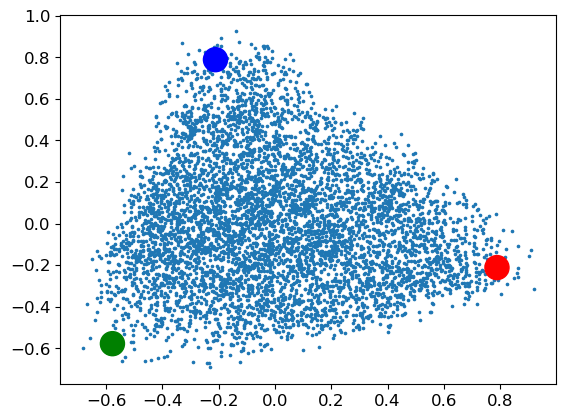

In [9]:
fig, ax = plt.subplots()
scprep.plot.scatter2d(archetypal_embedding.detach().numpy(), ax=ax)
scprep.plot.scatter2d(vertices_embedding.detach().numpy(), ax=ax, c=['red', 'blue', 'green'], s=300)

### Visualize average of 20 images nearest each archetype

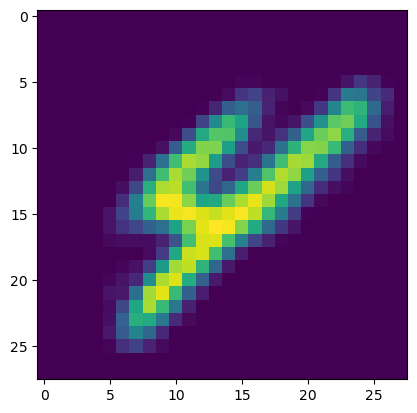

In [10]:
images_close_to_red_archetype_idx = np.argsort(barycentric_archetypal_embedding[:, 0])[::-1][:20]
images_close_to_red_archetype = data_digit[images_close_to_red_archetype_idx].reshape(20, 28, 28)
plt.imshow(images_close_to_red_archetype.mean(axis=0))

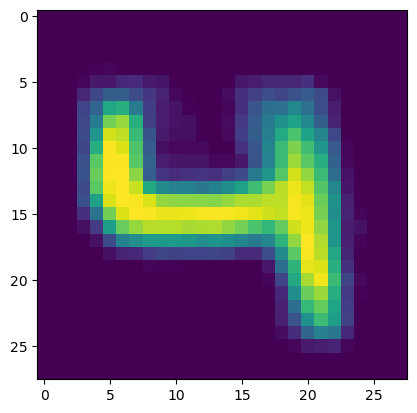

In [11]:
images_close_to_blue_archetype_idx = np.argsort(barycentric_archetypal_embedding[:, 1])[::-1][:20]
images_close_to_blue_archetype = data_digit[images_close_to_blue_archetype_idx].reshape(20, 28, 28)
plt.imshow(images_close_to_blue_archetype.mean(axis=0))

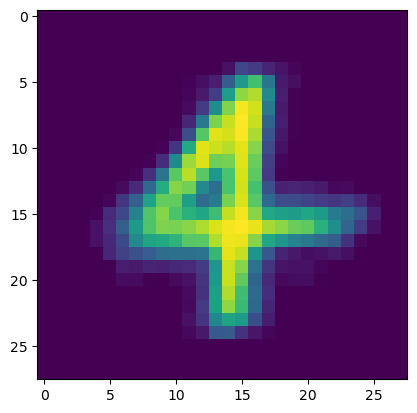

In [12]:
images_close_to_green_archetype_idx = np.argsort(barycentric_archetypal_embedding[:, 2])[::-1][:20]
images_close_to_green_archetype = data_digit[images_close_to_green_archetype_idx].reshape(20, 28, 28)
plt.imshow(images_close_to_green_archetype.mean(axis=0))